In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
λ_Re = np.log(2)/(41.2)
λ_U = np.log(2)/(4.468)
λ_Th = np.log(2)/(14.05)
λ_Rb = np.log(2)/(49.7)

In [4]:
#Setting initial parameters
#"Values from Nucleo-Cosmochronology and Chemical Evolution Modellings" and "the UTh production ratio and the age of the Milky Way from meteorites and Galactic halo stars.pdf"
M_tot_Tg = 56 # +/5     M⊙ pc^-1
M_gas_Tg = 13  # +/- 4     M⊙ pc^-1
ω = 0.0462 # +/- M⊙^-0.4 pc^0.8 Gyr^-1
schmidt_power = 1.4 # +/- 0.15
z1_yield = 0.5166
z2_yield = 1

N = 10000
t_max = 20
interval = t_max/(N-1)
time = np.linspace(0,t_max,N)

In [5]:
#Inflow rate distribution funtion
def normal_dist_function(t):
    tau = 3.46
    return (1/np.sqrt(2*np.pi*tau**2)) * np.exp(-((t-tau)**2)/(2*tau**2))
def exponential_dist_function(t):
    tau = 4.03
    return np.exp(-t/4.03)

#Calling the normal distribution function
M_inflow_rate = normal_dist_function(time)

#Creating the cumulative distribution curve, ie total mass at time t
M_tot = np.zeros(N)
M_tot[0] = 0
for i in range(N-1):
    M_tot[i+1] = (M_tot[i]+M_inflow_rate[i+1]*interval)

#The total mass at the end of the cdf can be used to normalise the pdf
norm = M_tot_Tg/M_tot[int(N*13.8/t_max)]

M_tot *= norm
M_inflow_rate *= norm

#Total mass of the gas calculation
#Change in the mass of the gas = Mass_inflow-ω*M_gas^schmidt_power
M_gas = np.zeros(N)
M_gas_RoC = np.zeros(N)
for i in range(N-1):
    M_gas_RoC[i] = M_inflow_rate[i] - ω*M_gas[i]**schmidt_power
    M_gas[i+1] = M_gas[i] + M_gas_RoC[i]*interval
    
#Rate of change of a given nuclide 
nuclei_concerntration_Th     = np.zeros(N)
nuclei_concerntration_RoC_Th = np.zeros(N)
nuclei_concerntration_U      = np.zeros(N)
nuclei_concerntration_RoC_U  = np.zeros(N)
nuclei_concerntration_Re     = np.zeros(N)
nuclei_concerntration_RoC_Re = np.zeros(N)
nuclei_concerntration_Os     = np.zeros(N) 
nuclei_concerntration_Rb     = np.zeros(N)
nuclei_concerntration_RoC_Rb = np.zeros(N)
nuclei_concerntration_Sr     = np.zeros(N) 
for i in range(N-1):
    #Calculating the relative nuclei concerntration of U and Th for the U/Th clock
    if M_gas[i] == 0:
        nuclei_concerntration_RoC_Th[i] = (z2_yield*ω*(M_gas[i+1]/8)**(schmidt_power-1))
    else:
        nuclei_concerntration_RoC_Th[i] = (z2_yield*ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_Th[i]) - (λ_Th*nuclei_concerntration_Th[i])
    nuclei_concerntration_Th[i+1] = nuclei_concerntration_Th[i] + nuclei_concerntration_RoC_Th[i]*interval

    if M_gas[i] == 0:
        nuclei_concerntration_RoC_U[i] = (z1_yield*ω*(M_gas[i+1]/8)**(schmidt_power-1))
    else:
        nuclei_concerntration_RoC_U[i] = (z1_yield*ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_U[i]) - (λ_U*nuclei_concerntration_U[i])
    nuclei_concerntration_U[i+1] = nuclei_concerntration_U[i] + nuclei_concerntration_RoC_U[i]*interval
    
    #Calculating the relative nuclei concerntration of Re for the OsRe clock
    if M_gas[i] == 0:
        nuclei_concerntration_RoC_Re[i] = (ω*(M_gas[i+1]/8)**(schmidt_power-1))
    else:
        nuclei_concerntration_RoC_Re[i] = (ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_Re[i]) - (λ_Re*nuclei_concerntration_Re[i])
    nuclei_concerntration_Re[i+1] = nuclei_concerntration_Re[i] + nuclei_concerntration_RoC_Re[i]*interval
    #Calculating the (r-process) relative nuclei concerntration for Os in the ReOs clock
    nuclei_concerntration_Os[i+1] = nuclei_concerntration_Os[i] + (λ_Re*nuclei_concerntration_Re[i]*interval)
    
    #Calculating the relative nuclei concerntration of Rb for the OsRe clock
    if M_gas[i] == 0:
        nuclei_concerntration_RoC_Rb[i] = (ω*(M_gas[i+1]/8)**(schmidt_power-1))
    else:
        nuclei_concerntration_RoC_Rb[i] = (ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_Rb[i]) - (λ_Rb*nuclei_concerntration_Rb[i])
    nuclei_concerntration_Rb[i+1] = nuclei_concerntration_Rb[i] + nuclei_concerntration_RoC_Rb[i]*interval
    #Calculating the (r-process) relative nuclei concerntration for Sr in the SrRb clock
    nuclei_concerntration_Sr[i+1] = nuclei_concerntration_Sr[i] + (λ_Rb*nuclei_concerntration_Rb[i]*interval)
    
UTh_ratio = nuclei_concerntration_U/nuclei_concerntration_Th
OsRe_ratio = nuclei_concerntration_Os/nuclei_concerntration_Re
SrRb_ratio = nuclei_concerntration_Sr/nuclei_concerntration_Rb

#Calculating the age of the universe in this case
if np.max(UTh_ratio < 0.438):
    tick = np.where(UTh_ratio < 0.438)[0][0]
    print('Age of the universe is {:2.2f}Gyr for the U/Th clock'.format(time[tick]+4.6))
    
if np.max(OsRe_ratio > 0.13):
    tick = np.where(OsRe_ratio > 0.13)[0][0]
    print('Age of the universe is {:2.2f}Gyr for the Os/Re clock'.format(time[tick]+4.6))
    
#Calculating the age of the universe in this case
if np.max(SrRb_ratio > 0.05):
    tick = np.where(SrRb_ratio > 0.05)[0][0]
    print('Age of the universe is {:2.2f}Gyr for the Sr/Rb clock'.format(time[tick]+4.6))

Age of the universe is 10.97Gyr for the U/Th clock
Age of the universe is 22.00Gyr for the Os/Re clock
Age of the universe is 12.95Gyr for the Sr/Rb clock


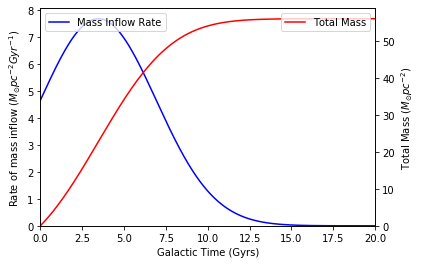

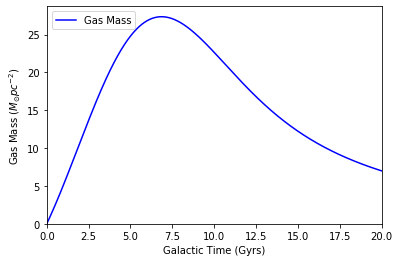

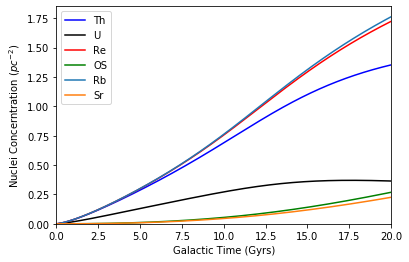

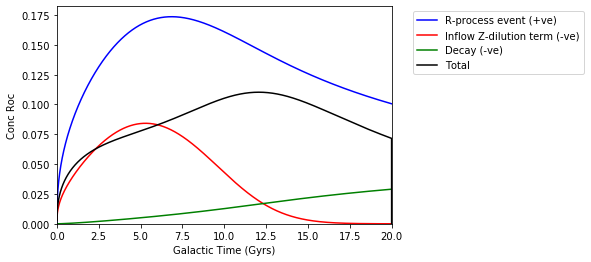

In [6]:
#Plotting the graph of mass and rate of change of mass of the galaxy
fig1,ax1 = plt.subplots()
ax2 = ax1.twinx() #Creating a second axis
ax1.plot(time,M_inflow_rate,'b',label='Mass Inflow Rate')
ax2.plot(time,M_tot,'r',label='Total Mass')
ax1.set_ylabel('Rate of mass inflow ($M_{⊙} pc^{-2} Gyr^{-1}$)')
ax2.set_ylabel('Total Mass ($M_{⊙} pc^{-2}$)')
ax1.set_xlabel('Galactic Time (Gyrs)')
ax1.set_xlim(0,t_max)
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')

#Plotting the graph of the gas mass within the galaxy
fig2,ax3 = plt.subplots()
ax3.plot(time,M_gas,'b',label='Gas Mass')
ax3.set_ylabel('Gas Mass ($M_{⊙} pc^{-2}$)')
ax3.set_xlabel('Galactic Time (Gyrs)')
ax3.set_xlim(0,t_max)
ax3.set_ylim(bottom=0)
ax3.legend(loc = 'upper left')

#Plotting the graph of the gas mass within the galaxy
fig3,ax4 = plt.subplots()
ax4.plot(time,nuclei_concerntration_Th,'b',label='Th')
ax4.plot(time,nuclei_concerntration_U ,'k',label='U')
ax4.plot(time,nuclei_concerntration_Re,'r',label='Re')
ax4.plot(time,nuclei_concerntration_Os,'g',label='OS')
ax4.plot(time,nuclei_concerntration_Rb    ,label='Rb')
ax4.plot(time,nuclei_concerntration_Sr    ,label='Sr')
ax4.set_ylabel('Nuclei Concerntration ($pc^{-2}$)')
ax4.set_xlabel('Galactic Time (Gyrs)')
ax4.set_xlim(0,t_max)
ax4.set_ylim(bottom=0)
ax4.legend(loc = 'upper left')

#Plotting the graph of the gas mass within the galaxy
fig7,ax8 = plt.subplots()
ax8.plot(time,ω*M_gas**(schmidt_power-1),'b',label='R-process event (+ve)')
ax8.plot(time,(M_inflow_rate/M_gas)*nuclei_concerntration_Re,'r',label='Inflow Z-dilution term (-ve)')
ax8.plot(time,λ_Re*nuclei_concerntration_Re,'g',label='Decay (-ve)')
ax8.plot(time,nuclei_concerntration_RoC_Re,'k',label='Total')
ax8.set_ylabel('Conc Roc')
ax8.set_xlabel('Galactic Time (Gyrs)')
ax8.set_xlim(0,t_max)
ax8.set_ylim(bottom=0)
ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Finding the age uncertainties based on the intial parameters.

In [7]:
def Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display):
    #Calling the normal distribution function
    M_inflow_rate = normal_dist_function(time)

    #Creating the cumulative distribution curve, ie total mass at time t
    M_tot = np.zeros(N)
    M_tot[0] = 0
    for i in range(N-1):
        M_tot[i+1] = (M_tot[i]+M_inflow_rate[i+1]*interval)

    #The total mass at the end of the cdf can be used to normalise the pdf
    norm = M_tot_Tg/M_tot[int(N*13.8/t_max)]

    M_tot *= norm
    M_inflow_rate *= norm

    #Total mass of the gas calculation
    #Change in the mass of the gas = Mass_inflow-ω*M_gas^schmidt_power
    M_gas = np.zeros(N)
    M_gas_RoC = np.zeros(N)
    for i in range(N-1):
        M_gas_RoC[i] = M_inflow_rate[i] - ω*M_gas[i]**schmidt_power
        M_gas[i+1] = M_gas[i] + M_gas_RoC[i]*interval

    #Rate of change of a given nuclide 
    nuclei_concerntration_Th     = np.zeros(N)
    nuclei_concerntration_RoC_Th = np.zeros(N)
    nuclei_concerntration_U      = np.zeros(N)
    nuclei_concerntration_RoC_U  = np.zeros(N)
    nuclei_concerntration_Re     = np.zeros(N)
    nuclei_concerntration_RoC_Re = np.zeros(N)
    nuclei_concerntration_Os     = np.zeros(N) 
    nuclei_concerntration_Rb     = np.zeros(N)
    nuclei_concerntration_RoC_Rb = np.zeros(N)
    nuclei_concerntration_Sr     = np.zeros(N) 
    for i in range(N-1):
        #Calculating the relative nuclei concerntration of U and Th for the U/Th clock
        if M_gas[i] == 0:
            nuclei_concerntration_RoC_Th[i] = (z2_yield*ω*(M_gas[i+1]/8)**(schmidt_power-1))
        else:
            nuclei_concerntration_RoC_Th[i] = (z2_yield*ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_Th[i]) - (λ_Th*nuclei_concerntration_Th[i])
        nuclei_concerntration_Th[i+1] = nuclei_concerntration_Th[i] + nuclei_concerntration_RoC_Th[i]*interval

        if M_gas[i] == 0:
            nuclei_concerntration_RoC_U[i] = (z1_yield*ω*(M_gas[i+1]/8)**(schmidt_power-1))
        else:
            nuclei_concerntration_RoC_U[i] = (z1_yield*ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_U[i]) - (λ_U*nuclei_concerntration_U[i])
        nuclei_concerntration_U[i+1] = nuclei_concerntration_U[i] + nuclei_concerntration_RoC_U[i]*interval

        #Calculating the relative nuclei concerntration of Re for the OsRe clock
        if M_gas[i] == 0:
            nuclei_concerntration_RoC_Re[i] = (ω*(M_gas[i+1]/8)**(schmidt_power-1))
        else:
            nuclei_concerntration_RoC_Re[i] = (ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_Re[i]) - (λ_Re*nuclei_concerntration_Re[i])
        nuclei_concerntration_Re[i+1] = nuclei_concerntration_Re[i] + nuclei_concerntration_RoC_Re[i]*interval
        #Calculating the (r-process) relative nuclei concerntration for Os in the ReOs clock
        nuclei_concerntration_Os[i+1] = nuclei_concerntration_Os[i] + (λ_Re*nuclei_concerntration_Re[i]*interval)

        #Calculating the relative nuclei concerntration of Rb for the OsRe clock
        if M_gas[i] == 0:
            nuclei_concerntration_RoC_Rb[i] = (ω*(M_gas[i+1]/8)**(schmidt_power-1))
        else:
            nuclei_concerntration_RoC_Rb[i] = (ω*M_gas[i]**(schmidt_power-1)) - ((M_inflow_rate[i]/M_gas[i])*nuclei_concerntration_Rb[i]) - (λ_Rb*nuclei_concerntration_Rb[i])
        nuclei_concerntration_Rb[i+1] = nuclei_concerntration_Rb[i] + nuclei_concerntration_RoC_Rb[i]*interval
        #Calculating the (r-process) relative nuclei concerntration for Sr in the SrRb clock
        nuclei_concerntration_Sr[i+1] = nuclei_concerntration_Sr[i] + (λ_Rb*nuclei_concerntration_Rb[i]*interval)

    UTh_ratio = nuclei_concerntration_U/nuclei_concerntration_Th
    OsRe_ratio = nuclei_concerntration_Os/nuclei_concerntration_Re
    SrRb_ratio = nuclei_concerntration_Sr/nuclei_concerntration_Rb

    #Calculating the age of the universe in this case
    if np.max(UTh_ratio < 0.438+0.006) and display==1:
        upper_tick = np.where(UTh_ratio < 0.438+0.006)[0][0]
        lower_tick = np.where(UTh_ratio < 0.438-0.006)[0][0]
        print('Age of the universe is between {:2.3f} and {:2.3f}Gyr for the U/Th clock'.format(time[upper_tick]+4.6,time[lower_tick]+4.6))

    if np.max(OsRe_ratio > 0.13+0.008203) and display==2:
        upper_tick = np.where(OsRe_ratio > 0.13-0.008203)[0][0]
        lower_tick = np.where(OsRe_ratio > 0.13+0.008203)[0][0]
        print('Age of the universe is between {:2.3f} and {:2.3f}Gyr for the Os/Re clock'.format(time[upper_tick]+4.6,time[lower_tick]+4.6))

    #Calculating the age of the universe in this case
    if np.max(SrRb_ratio > 0.05+0.03) and display==3:
        upper_tick = np.where(SrRb_ratio > 0.05-0.03)[0][0]
        lower_tick = np.where(SrRb_ratio > 0.05+0.03)[0][0]
        print('Age of the universe is between {:2.3f} and {:2.3f}Gyr for the Sr/Rb clock'.format(time[upper_tick]+4.6,time[lower_tick]+4.6))
        
    return UTh_ratio,OsRe_ratio,SrRb_ratio

In [8]:
#----------------------------------------------
#FOR UTH
print('FOR UTh')
#----------------------------------------------
#lower age
M_tot_Tg = 56-5 # +/5     M⊙ pc^-1
M_gas_Tg = 13# +/- 4     M⊙ pc^-1
schmidt_power = 1.25 # +/- 0.15
z1_yield = 0.3#5166
UTh_ratio_lower,na,na2 = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=1)
#upper age
M_tot_Tg = 56+5 # +/5     M⊙ pc^-1
M_gas_Tg = 13 # +/- 4     M⊙ pc^-1
schmidt_power = 1.4+0.15 # +/- 0.15
z1_yield = 0.76#5166
UTh_ratio_higher,na,na2 = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=1)
print()
#----------------------------------------------
#FOR OsRe
print('FOR OsRe')
#----------------------------------------------
#lower age
M_tot_Tg = 56+5 # +/5     M⊙ pc^-1
M_gas_Tg = 13# +/- 4     M⊙ pc^-1
schmidt_power = 1.4+0.15 # +/- 0.15
na,OsRe_ratio_lower,na2 = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=2)
#upper age
M_tot_Tg = 56-5 # +/5     M⊙ pc^-1
M_gas_Tg = 13 # +/- 4     M⊙ pc^-1
schmidt_power = 1.4-0.15 # +/- 0.15
na,OsRe_ratio_higher,na2 = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=2)
print()
#----------------------------------------------
#FOR SrRb - Uncertainties move depending on the age hence 2 sets of limits
print('FOR SrRb')
#----------------------------------------------
#lower age
M_tot_Tg = 56+5 # +/5     M⊙ pc^-1
M_gas_Tg = 13# +/- 4     M⊙ pc^-1
schmidt_power = 1.4+0.15 # +/- 0.15
na,na2,SrRb_ratio_lower = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=3)
#lower age
M_tot_Tg = 56-5 # +/5     M⊙ pc^-1
M_gas_Tg = 13# +/- 4     M⊙ pc^-1
schmidt_power = 1.4-0.15 # +/- 0.15
na,na2,SrRb_ratio_lower2 = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=3)
#upper age
M_tot_Tg = 56-5 # +/5     M⊙ pc^-1
M_gas_Tg = 13 # +/- 4     M⊙ pc^-1
schmidt_power = 1.4+0.15 # +/- 0.15
na,na2,SrRb_ratio_higher = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=3)
#upper age
M_tot_Tg = 56-5 # +/5     M⊙ pc^-1
M_gas_Tg = 13 # +/- 4     M⊙ pc^-1
schmidt_power = 1.4-0.15 # +/- 0.15
na,na2,SrRb_ratio_higher2 = Age_function(λ_Re,λ_U,λ_Th,λ_Rb,M_tot_Tg,M_gas_Tg,ω,schmidt_power,z1_yield,z2_yield,N,t_max,interval,time,display=3)



FOR UTh
Age of the universe is between 4.602 and 4.602Gyr for the U/Th clock
Age of the universe is between 21.344 and 21.960Gyr for the U/Th clock

FOR OsRe
Age of the universe is between 20.356 and 22.044Gyr for the Os/Re clock
Age of the universe is between 21.588 and 23.454Gyr for the Os/Re clock

FOR SrRb
Age of the universe is between 8.088 and 17.433Gyr for the Sr/Rb clock
Age of the universe is between 7.764 and 18.447Gyr for the Sr/Rb clock
Age of the universe is between 8.110 and 17.573Gyr for the Sr/Rb clock
Age of the universe is between 7.764 and 18.447Gyr for the Sr/Rb clock


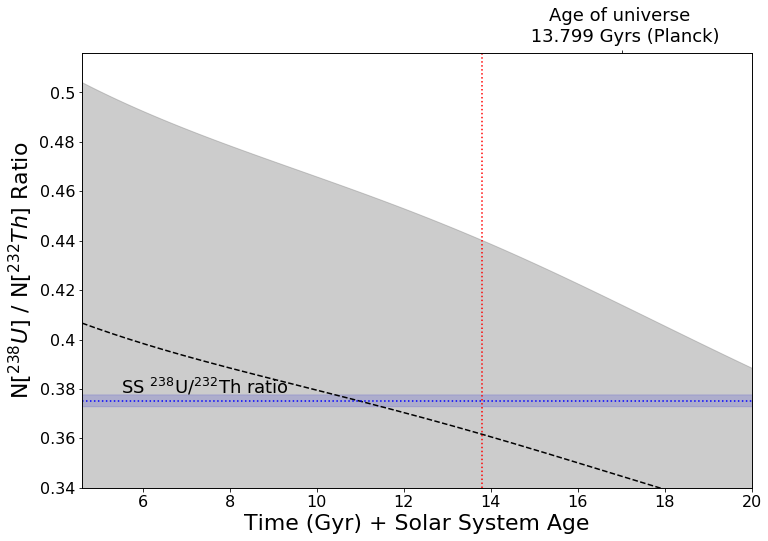

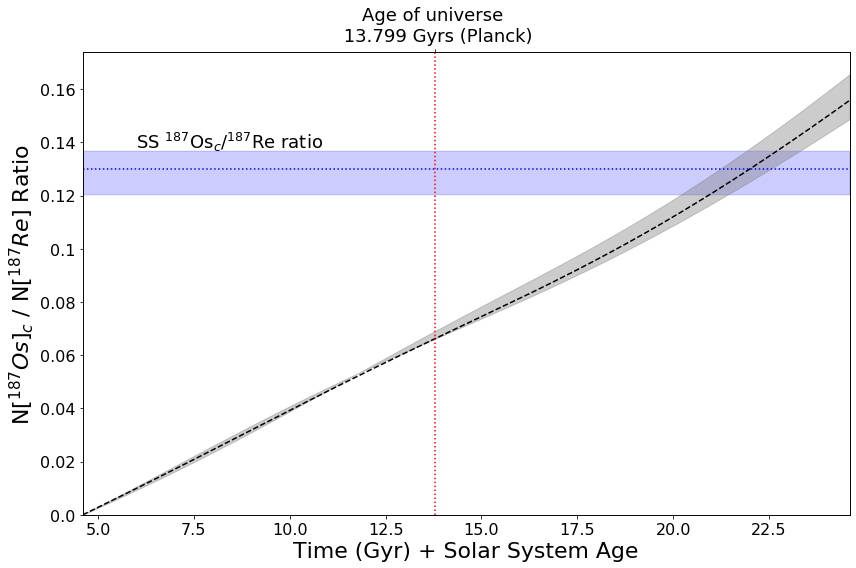

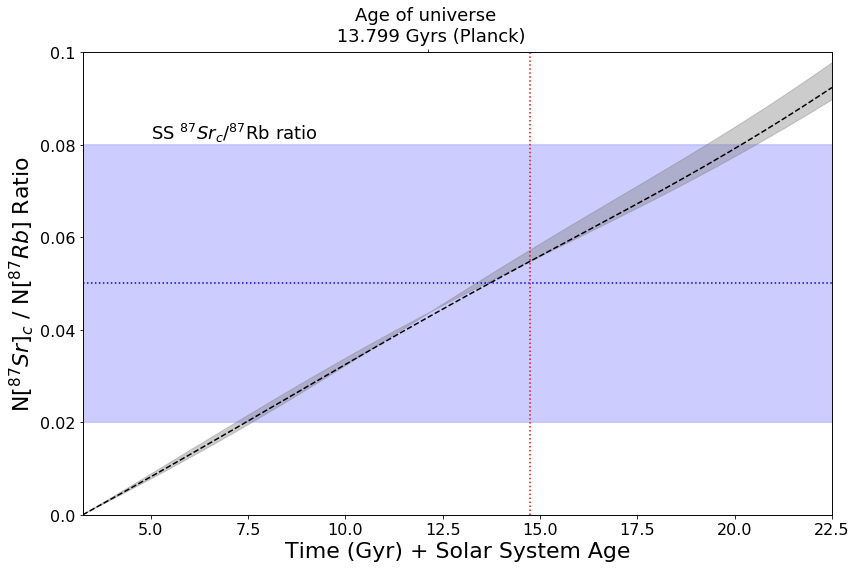

In [15]:
#Plotting the graph of the UTh ratio
fig4, ax5 = plt.subplots(1,1,figsize=(12,8))
ax5.plot(time+4.6,UTh_ratio,'k--',label='U/Th Ratio')
ax5.plot([4.6,24.6],[0.438 ,0.438],'b:')
ax5.axvline(13.799,0,1,color='r',linestyle=':',alpha=1)
x = np.arange(4.6,t_max+4.6,0.01)
y1 = np.array([0.438+0.006]*len(x))
y2 = np.array([0.438-0.006]*len(x))
ax5.fill_between(x,y2, y1,alpha=0.2, color='b')
ax5.fill_between(time+4.6,UTh_ratio_lower,UTh_ratio_higher,alpha=0.4, color='grey')
ax5.set_xlabel('Time (Gyr) + Solar System Age',fontsize=22)
ax5.set_ylabel(r'N$[^{238}U]$ / N$[^{232}Th]$ Ratio',fontsize=22)
ax5.set_xlim([4.6,20])
ax5.set_ylim(bottom=0.35)
ax5.set_xticklabels([4,6,8,10,12,14,16,18,20,22],fontsize=16)
ax5.set_yticklabels([0.34,0.36,0.38,0.40,0.42,0.44,0.46,0.48,0.50,0.52],fontsize=16)
ax51 = ax5.twiny()
ax51.set_xticks([0.807])
ax51.set_xticklabels(["Age of universe \n 13.799 Gyrs (Planck)"],fontsize=18)
ax5.text(5.5,0.445,'SS $^{238}$U/$^{232}$Th ratio',fontsize=18)

#Plotting the graph of the OsRe ratio
fig5, ax6 = plt.subplots(1,1,figsize=(12,8))
ax6.plot(time+4.6,OsRe_ratio,'k--',label='ReOs Ratio')
ax6.plot([4.6,t_max+4.6],[0.13,0.13],'b:')
ax6.axvline(13.799,0,1,color='r',linestyle=':',alpha=1)
x = np.arange(4.6,t_max+4.6,0.01)
y1 = np.array([0.12868+0.008203]*len(x))
y2 = np.array([0.12868-0.008203]*len(x))
ax6.fill_between(x,y2, y1,alpha=0.2, color='b')
ax6.fill_between(time+4.6,OsRe_ratio_lower,OsRe_ratio_higher,alpha=0.4, color='grey')
ax6.set_xlabel('Time (Gyr) + Solar System Age',fontsize=22)
ax6.set_ylabel('N$[^{187}Os]_{c}$ / N$[^{187}Re]$ Ratio',fontsize=22)
ax6.set_xlim([4.6,t_max+4.6])
ax6.set_ylim(bottom=0)
ax6.set_xticklabels(np.linspace(2.5,22.5,9),fontsize=16)
ax6.set_yticklabels(np.linspace(0,0.16,9),fontsize=16)
ax61 = ax6.twiny()
ax61.set_xticks([0.46])
ax61.set_xticklabels(["Age of universe \n 13.799 Gyrs (Planck)"],fontsize=18)
ax6.text(6,0.138,'SS $^{187}$Os$_{c}$/$^{187}$Re ratio',fontsize=18)
plt.tight_layout()

#Plotting the graph of the SrRb ratio
fig6, ax7 = plt.subplots(1,1,figsize=(12,8))
ax7.plot(time+4.6,SrRb_ratio,'k--',label='SrRb Ratio')
ax7.plot([4.6,t_max+4.6],[0.05,0.05],'b:')
ax7.axvline(13.799,0,1,color='r',linestyle=':',alpha=1)
x = np.arange(4.6,t_max+4.6,0.01)
y1 = np.array([0.05+0.03]*len(x))
y2 = np.array([0.05-0.03]*len(x))
ax7.fill_between(x,y2, y1,alpha=0.2, color='b')
ax7.fill_between(time+4.6,SrRb_ratio_lower,SrRb_ratio_higher2,alpha=0.4, color='grey')
#ax7.fill_between(time+4.6,SrRb_ratio_lower2,SrRb_ratio_higher,alpha=0.2, color='green')
#ax7.axvspan(8.9+4.6,9.5+4.6,0,1,color='r',alpha=0.3)
ax7.set_xlabel('Time (Gyr) + Solar System Age',fontsize=22)
ax7.set_ylabel('N$[^{87}Sr]_{c}$ / N$[^{87}Rb]$ Ratio',fontsize=22)
ax7.set_xlim([4.6,20])
ax7.set_ylim(0,0.10)
ax7.set_xticklabels(np.linspace(2.5,22.5,9),fontsize=16)
ax7.set_yticklabels(np.linspace(0,0.10,6),fontsize=16)
ax71 = ax7.twiny()
ax71.set_xticks([0.461])
ax71.set_xticklabels(["Age of universe \n 13.799 Gyrs (Planck)"],fontsize=18)
ax7.text(6,0.0812,'SS $^{87}Sr$$_{c}$/$^{87}$Rb ratio',fontsize=18)
plt.tight_layout()
plt.show()

[]

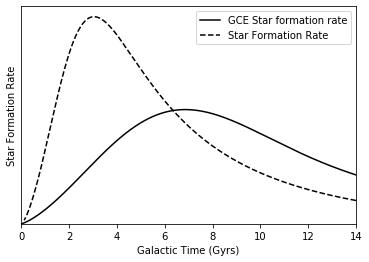

In [10]:
#Comparison of the r-process event rate compared to the star formation rate seen in UV observations

def rate_1_calculation():
    Z = np.linspace(0,14,10000)
    SFR = (0.015*(1+Z)**2.7)/(1+((1+Z)/2.9)**5.6)    
    time = 28/(1+(1+Z)**2)
    return time,SFR
time2,SFR = rate_1_calculation()

#Plotting the graph of the gas mass within the galaxy
fig8,ax9 = plt.subplots()
ax9.plot(time,ω*M_gas**(schmidt_power),'k',label='GCE Star formation rate')
ax9.plot(time2,39.40594110790468*SFR,'k--',label='Star Formation Rate')
ax9.set_ylabel('Star Formation Rate')
ax9.set_xlabel('Galactic Time (Gyrs)')
ax9.set_xlim(0,14)
ax9.set_ylim(bottom=0)
#ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax9.legend()
ax9.axes.yaxis.set_ticks([])

In [11]:
event_rate = ω*M_gas**(schmidt_power)
print(sum(event_rate[:6999]))

13289.18527220752


In [12]:
print(sum(event_rate[:6999])/sum(SFR))

39.40594110790468
